In [ ]:
%%capture
# capture는 주렁주렁 출력 보여주지 않게끔
# 그래프에서 한글이 깨지지 않게 폰트 설치..
# *맨처음에 셀 한 번 실행하고 세션 다시 시작하고 또 실행해야 반영됨!!
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

In [ ]:
%%capture
!pip install gdown
!pip install transformers
!pip install sentencepiece # MarianTokenizer 불러올 때 필요
!pip install sacremoses # MarianMTModel 에서 불러올 때 warning 뜨는 것 방지
!pip install einops # 지리는 einops 쓰기 (Einstein operations)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from transformers import MarianMTModel, MarianTokenizer # MT: Machine Translation
import pandas as pd
from tqdm import tqdm
import math
from einops import rearrange

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cpu


In [ ]:
# Load the tokenizer & input embedding layer & last fc layer
tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-ko-en')
model = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-ko-en') # MT: Machine Translation
# input_embedding = model.get_input_embeddings() # 일부 사이즈 큰 놈들은 데려와서 나머지만 학습시키려는 시도
# input_embedding.weight.requires_grad = False # freeze
# fc_out = model.get_output_embeddings()
# fc_out.weight.requires_grad = False

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
eos_idx = tokenizer.eos_token_id
pad_idx = tokenizer.pad_token_id
print("eos_idx = ", eos_idx)
print("pad_idx = ", pad_idx)

eos_idx =  0
pad_idx =  65000


## 하이퍼파라미터 조정

In [ ]:
BATCH_SIZE = 64 # 논문에선 2.5만 token이 한 batch에 담기게 했다고 함.
LAMBDA = 0 # l2-Regularization를 위한 hyperparam. # 저장된 모델
EPOCH = 15 # 저장된 모델
# max_len = 512 # model.model.encoder.embed_positions 를 보면 512로 했음을 알 수 있다.
max_len = 100 # 너무 긴거 같아서 자름 (GPU 부담도 많이 덜어짐)
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx) # pad token 이 출력 나와야하는 시점의 loss는 무시 (즉, label이 <pad> 일 때는 무시) # 저장된 모델
# criterion = nn.CrossEntropyLoss(ignore_index = pad_idx, label_smoothing = 0.1) # 막상 해보니 성능 안나옴 <- 데이터가 많아야 할 듯

scheduler_name = 'Noam'
# scheduler_name = 'Cos'
#### Noam ####
# warmup_steps = 4000 # 이건 논문에서 제시한 값 (총 10만 step의 4%)
warmup_steps = 1500 # 데이터 수 * EPOCH / BS = 총 step 수 인것 고려 # 저장된 모델
LR_scale = 0.5 # Noam scheduler에 peak LR 값 조절을 위해 곱해질 녀석 # 저장된 모델
#### Cos ####
LR_init = 5e-4
T0 = 1500 # 첫 주기
T_mult = 2 # 배 만큼 주기가 길어짐 (1보다 큰 정수여야 함)
#############

new_model_train = False
hyuk_model_use = True # 여러분만의 모델 만들어서 사용하고 싶다면 False로

if hyuk_model_use:
    !gdown https://drive.google.com/uc?id=1bjbeWgqlVKJ9gzDcL1hfD9cIItQy9_N2 -O Transformer_small.pt
    !gdown https://drive.google.com/uc?id=1M0yYP2umxlwaAbk_iq5G_Z5y3qLu9Wet -O Transformer_small_history.pt

    save_model_path = 'Transformer_small.pt'
    save_history_path = 'Transformer_small_history.pt'
else:
    save_model_path = '/content/drive/MyDrive/Colab Notebooks/results/Transformer_small2.pt'
    save_history_path = '/content/drive/MyDrive/Colab Notebooks/results/Transformer_small2_history.pt'

Downloading...
From: https://drive.google.com/uc?id=1bjbeWgqlVKJ9gzDcL1hfD9cIItQy9_N2
To: /content/Transformer_small.pt
100% 448M/448M [00:05<00:00, 82.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1M0yYP2umxlwaAbk_iq5G_Z5y3qLu9Wet
To: /content/Transformer_small_history.pt
100% 775/775 [00:00<00:00, 2.54MB/s]


In [ ]:
vocab_size = tokenizer.vocab_size
print(vocab_size)

# 논문에 나오는 base 모델 (train loss를 많이 줄이려면 많은 Epoch이 요구됨, 또, test 성능도 좋으려면 더 많은 데이터 요구)
# n_layers = 6
# d_model = 512
# d_ff = 2048
# n_heads = 8
# drop_p = 0.1

# 좀 사이즈 줄인 모델 (훈련된 input_embedding, fc_out 사용하면 사용 불가)
n_layers = 3
d_model = 256
d_ff = 512
n_heads = 8
drop_p = 0.1

65001


## 토크나이저 & 학습된 모델 써보기

In [ ]:
# tokenizer 써보기 (_로 띄어쓰기를 나타낸다! 즉, _가 없으면 이어진 한 단어임을 나타냄 subword tokenizing)
# 토크나이저에 대해 참고 자료: https://ratsgo.github.io/nlpbook/docs/preprocess/bpe/
print(tokenizer.tokenize("Hi, I'm Hyuk. ...        a   a?"))
print(tokenizer.tokenize("a/b 1+2+3 2:1 a>b"))
print(tokenizer.tokenize("pretrained restart"))
print(tokenizer.tokenize("chatGPT"))
print(tokenizer.tokenize("The example is very good in our lecture")) # 띄어쓰기도 tokenize 할 때가 있다.
print(tokenizer.tokenize("한글은 어떻게 할까?"))
print(tokenizer.tokenize("확실히 띄어쓰기 기준으로 토크나이징을 하는 것 같진 않다."))
print(tokenizer.tokenize("조사는? 나는 너는 우리는 강의는 너와 나의 내가 너가 나무가 헿"))
print(tokenizer.tokenize("마음대로 추가 문장"))

['▁H', 'i', ',', '▁I', "'", 'm', '▁H', 'y', 'u', 'k', '.', '▁', '...', '▁a', '▁a', '?']
['▁a', '/', 'b', '▁1', '+2', '+3', '▁2:', '1', '▁a', '>', 'b']
['▁p', 're', 'tra', 'in', 'ed', '▁re', 'st', 'art']
['▁ch', 'at', 'G', 'P', 'T']
['▁The', '▁', 'ex', 'am', 'ple', '▁is', '▁', 'very', '▁good', '▁in', '▁', 'our', '▁', 'le', 'c', 'ture']
['▁한', '글', '은', '▁어떻게', '▁할까', '?']
['▁확실히', '▁띄', '어', '쓰기', '▁기준으로', '▁토', '크', '나이', '징', '을', '▁하는', '▁것', '▁같', '진', '▁않다', '.']
['▁조사', '는', '?', '▁나는', '▁너는', '▁우리는', '▁강의', '는', '▁너와', '▁나의', '▁내가', '▁너가', '▁나무가', '▁', '헿']
['▁마음대로', '▁추가', '▁문장']


In [ ]:
print(tokenizer.get_vocab())
print(tokenizer.vocab_size)

print(tokenizer.encode('지능', add_special_tokens=False)) # string to index
print(tokenizer.encode('<pad>', add_special_tokens=False)) # <pad>는 65000
print(tokenizer.encode('</s>', add_special_tokens=False)) # <sos> or <eos>는 0
print(tokenizer.encode('He', add_special_tokens=False)) # add_special_tokens=False 는 <eos> 자동 붙여주는 것을 방지
print(tokenizer.encode('he', add_special_tokens=False)) # 대소문자 다른 단어로 인식
print(tokenizer.tokenize('문장을 넣으면 토크나이즈해서 숫자로 바꾼다'))
print(tokenizer.encode('문장을 넣으면 토크나이즈해서 숫자로 바꾼다', add_special_tokens=False))
print(tokenizer.decode([204]))
print(tokenizer.decode([206]))
print(tokenizer.decode([210]))
print(tokenizer.decode(list(range(15)) + [65000,65001,65002,65003]))

{'</s>': 0, '<unk>': 1, '.': 2, ',': 3, '▁the': 4, '▁to': 5, '▁of': 6, '?': 7, '▁and': 8, '▁': 9, 's': 10, '▁a': 11, "'": 12, '▁in': 13, '▁들': 14, '▁that': 15, '▁I': 16, '▁”': 17, '▁you': 18, '▁“': 19, '▁is': 20, '▁이': 21, '▁-': 22, '▁을': 23, '▁it': 24, '▁의': 25, '▁for': 26, '▁은': 27, '!': 28, '▁에': 29, '▁’': 30, '▁be': 31, '▁‘': 32, '▁with': 33, '▁not': 34, '▁was': 35, '▁have': 36, '▁we': 37, '▁are': 38, '▁on': 39, '▁가': 40, '▁는': 41, '▁this': 42, '▁를': 43, '▁그': 44, '▁—': 45, ':': 46, '’': 47, '이': 48, 't': 49, '▁as': 50, '을': 51, ')': 52, '의': 53, '▁한': 54, '는': 55, '▁they': 56, '▁The': 57, '▁(': 58, '▁he': 59, '▁his': 60, '▁will': 61, '가': 62, '▁God': 63, '에': 64, '▁from': 65, '...': 66, '▁can': 67, '▁by': 68, '▁your': 69, '▁And': 70, '▁what': 71, '▁do': 72, '▁all': 73, '▁에서': 74, '▁me': 75, '▁으로': 76, '▁their': 77, '▁or': 78, '를': 79, '▁one': 80, '▁who': 81, '▁them': 82, '▁at': 83, '▁my': 84, '고': 85, '▁[': 86, '▁You': 87, '▁과': 88, '▁로': 89, '▁Jehovah': 90, '▁It': 91, '은': 92, '▁

In [ ]:
# 사전 학습된 모델로 번역해보기 (생각보다 성능 좋네)
input_text = "헐! 대박 쩐다!"

input_tokens = tokenizer.encode(input_text, return_tensors="pt")
translated_tokens = model.generate(input_tokens, max_new_tokens=max_len) # shape = (batch, seq)
translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)

print("입력:", input_text)
print("AI의 번역:", translated_text)

입력: 헐! 대박 쩐다!
AI의 번역: Oh, my God! That's awesome!


## DS, DL 생성 & 테스트

In [ ]:
# data 다운
# %%capture
# https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=126 에서 받을 수 있어요
!gdown https://drive.google.com/uc?id=1r4ZnFJOStyBlNRx7snBQ-Iq2GNyJKL6t -O '대화체.xlsx'

Downloading...
From: https://drive.google.com/uc?id=1r4ZnFJOStyBlNRx7snBQ-Iq2GNyJKL6t
To: /content/대화체.xlsx
100% 9.57M/9.57M [00:00<00:00, 29.6MB/s]


In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data.loc[idx, '원문'], self.data.loc[idx, '번역문']

data = pd.read_excel('대화체.xlsx')
custom_DS = CustomDataset(data)

train_DS, val_DS, test_DS, _ = torch.utils.data.random_split(custom_DS, [95000, 2000, 1000, len(custom_DS)-95000-2000-1000])
# 논문에서는 450만개 영,독 문장 pair 사용

train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

print(len(train_DS))
print(len(val_DS))
print(len(test_DS))

95000
2000
1000


In [ ]:
# test_DS 테스트
i = 5
idx = test_DS.indices[i]
print(idx) # 엑셀 파일에서 idx번째 문장에 들어있음을 확인할 수 있다
src_text, trg_text = custom_DS.__getitem__(idx)
print(src_text)
print(trg_text)

93521
다른 추석 선물 세트는 오른편에 보시면 잔뜩 있습니다.
There are a bunch of other Chuseok gift sets on the right.


In [ ]:
# train_DL 테스트
src_texts, trg_texts = next(iter(train_DL)) # 데이터 한 국자 뜨기

print(src_texts)
print(trg_texts)
print(len(src_texts))
print(len(trg_texts))

# 여러 문장에 대해서는 tokenizer.encode() 가 아닌 그냥 tokenizer()
src = tokenizer(src_texts, padding=True, truncation=True, max_length = max_len, return_tensors='pt').input_ids # pt: pytorch tensor로 변환
# add_special_tokens = True (default)면 마지막 토큰에 <eos> 가 붙어 나옴
# truncation = True: max_len 보다 길면 끊고 <eos> 집어넣어버림
# src에 <eos>가 있는 게 반드시 좋은 건지는 알 수 없지만 그냥 붙여봤어요..
trg_texts = ['</s> ' + s for s in trg_texts]
trg = tokenizer(trg_texts, padding=True, truncation=True, max_length = max_len, return_tensors='pt').input_ids

print(src[:2])
print(trg[:2])
print(src.shape)
print(trg.shape)
print(trg[:,-1]) # 가장 마지막 단어를 보니 어떤 문장은 <eos> 로 끝이 났고 나머지는 <pad> 로 끝이 났다는 걸 볼 수 있음
print(tokenizer.decode(trg[trg[:,-1]==eos_idx,:][0])) # 가장 긴 문장 중 첫 번째 문장 관찰
print(trg[5,:-1]) # 디코더 입력
print(trg[5,1:]) # 디코더 출력
# 그런데 [:,:-1] 로 주면 패딩된 문장은 eos도 넣는 셈 아닌가? 맞다! 하지만 괜찮다. 어차피 출력으로 pad token이 기다리고 있으니.. (loss에서 ignore됨)

('팀원들 모두 열심히 준비했는데 성과가 좋아서 기분이 좋아요.', '그래도 모든 직원이 나오게 찍는 사진이니까 촬영에 임해주셨으면 좋겠어요.', '제품에 문제가 있어서 교환하는 경우에는 저희가 택배비를 내드립니다.', '구글 클라우드 서비스로 변경하는 것은 어떻습니까?', '네, 개발되는 화장품에 관심이 많더라고요.', '분명 객실을 예약할 때 침대 2개를 했는데 1개 밖에 없네요.', '요즘은 점심 회식도 많다고 하는데 그런 거 해볼까 싶어요.', '경찰서에서 범죄 수사경력회보서를 발급받을 수 있어요.', '네, 색다른 즐거움과 재미를 위한 협업을 했습니다.', '저쪽 민원실 옆 투명한 방에 가시면 복사랑 팩스 이용하실 수 있어요.', '이곳에서 4박 5일을 묵는 건 무리였을지도 모르겠다.', '저도 그래요, 매년 이 일을 어떻게 하는지 모르겠어요.', '그렇지만 화장을 하거나 꾸밀 수가 없잖아.', '사실 때 받았던 영수증을 보여주시면 환불해드리겠습니다.', '면세점에서 꽤 많이 샀는데, 혹시 과세가 되지는 않을까요?', '크게 불편한 건 없고, 전부 한 봉투에 담아서 주세요.', '회사 앞에 새로 생긴 식당 있다는데, 거기 가볼래?', '응, 그냥 클라이맥스만 강조하려다 보니 오히려 지루해.', '다른 회사는 많이들 자율근무제 시행하던데.', '합격자 발표가 난 곳도 있나요?', '직장 다니니까 그런 프로그램 볼 시간이 없었지.', '그 정도까지는 힘들 것 같은데, 외부에서 찾아볼까요?', '수술 일자, 상병명 다 기재되어 있는 건가요?', '우리 다 같이 식사하려고 하는데, 같이 하실래요?', '가구 만드는 거 네 생각보다 그렇게 어렵지 않아.', '계속 같은 현상이 일어난다면 다시 한번 방문 수리를 받아보시겠어요?', '여러 가지 방법들이 있지만, 셔틀버스를 추천합니다.', '오늘은 너만을 위한 날이야.', '조금만 더 따뜻하게 해주시면 딱 좋을 것 같아요.', '시내의 모든 도로의 규정 속도가 50km/h로 바뀐 거 알아?', '연기 때문에 불빛도

In [ ]:
# 내가 쓸 train data 에 대해서 기존 model이 잘 번역하는지 확인
i = 5
idx = train_DS.indices[i]
src_text, trg_text = custom_DS.__getitem__(idx)
print(f"입력: {src_text}")
print(f"정답: {trg_text}")

src = tokenizer.encode(src_text, return_tensors='pt', add_special_tokens = True)
# add_special_tokens = False 해보면 뭔가 이상하게 번역함 (학습 때 source에도 <eos>를 넣었단 증거?)
translated_tokens = model.generate(src, max_new_tokens=max_len)
translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=False)

print(f"AI의 번역: {translated_text}") # 디코더 첫 입력으로 <pad> 토큰을 넣었음. (<pad>를 <sos>로 사용)

입력: 야간 담당 간호사분께서 근무 중이시니 호출 벨을 눌러주시면 간호사가 올 겁니다.
정답: We have a nurse on a night shift, press the bell and she'll come right over.
AI의 번역: <pad> The night nurse is on duty, so if you can press the call bell, the nurse will come.</s>


## 모델 구현

### Multi-Head Attention

In [ ]:
class MHA(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()

        self.n_heads = n_heads

        self.fc_q = nn.Linear(d_model, d_model) # 차 or 개x차 or 개x개x차 로 입력해줘야
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.fc_o = nn.Linear(d_model, d_model)

        self.scale = torch.sqrt(torch.tensor(d_model / n_heads))

    def forward(self, Q, K, V, mask = None):

        Q = self.fc_q(Q) # 개단차
        K = self.fc_k(K)
        V = self.fc_v(V)

        Q = rearrange(Q, '개 단 (헤 차) -> 개 헤 단 차', 헤 = self.n_heads) # 개단차 -> 개헤단차
        K = rearrange(K, '개 단 (헤 차) -> 개 헤 단 차', 헤 = self.n_heads)
        V = rearrange(V, '개 단 (헤 차) -> 개 헤 단 차', 헤 = self.n_heads)

        attention_score = Q @ K.transpose(-2,-1)/self.scale # 개헤단단

        if mask is not None:
            attention_score[mask] = -1e10
        attention_weights = torch.softmax(attention_score, dim=-1) # 개헤단단

        attention = attention_weights @ V # 개헤단차

        x = rearrange(attention, '개 헤 단 차 -> 개 단 (헤 차)') # 개헤단차 -> 개단차
        x = self.fc_o(x) # 개단차

        return x, attention_weights

        # einops를 알기전
        # batch_size = Q.shape[0]

        # Q = self.fc_q(Q) # 개단차
        # K = self.fc_k(K)
        # V = self.fc_v(V)

        # Q = Q.reshape(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3) # 개헤단차를 만들어줘야 한다 (QK^TV 연산을 위해)
        # K = K.reshape(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3) # 이 때, 개단차 -> 개단헤차 -> 개헤단차
        # V = V.reshape(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3) # 이 순서로 해야 reshape할 때 512를 8개로 쪼갬!!!

        # attention_score = Q@K.permute(0,1,3,2)/self.scale # 개헤단단

        # if mask is not None:
        #     attention_score[mask] = -1e10 # mask.shape = 개헤단단
        # attention_weights = torch.softmax(attention_score, dim=-1) # 개헤단단

        # attention = attention_weights @ V # 개헤단차

        # x = attention.permute(0,2,1,3) # 개단헤차
        # x = x.reshape(batch_size, -1, self.d_model) # 개단차

        # x = self.fc_o(x) # 개단차

        # return x, attention_weights

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, drop_p):
        super().__init__()

        self.linear = nn.Sequential(nn.Linear(d_model, d_ff),
                                    nn.ReLU(),
                                    nn.Dropout(drop_p), # 논문에는 명시되어 있지 않지만.. overfitting 취약한 부분이라
                                    nn.Linear(d_ff, d_model))

    def forward(self, x):
        x = self.linear(x)
        return x

#### rearrange, scaling 실험

In [ ]:
Q = torch.randn(1, 4, 6) # 개단차
print(Q)

Q = rearrange(Q, '개 단 (헤 차) -> 개 헤 단 차', 헤 = 3) # 개단차 -> 개헤단차
# 주의! (차 헤) 로 해보면 또 다름. 차원의 수 6을 헤드의 수 3으로 쪼개는 것이므로 (헤 차) 가 맞다
print(Q)

x = rearrange(Q, '개 헤 단 차 -> 개 단 (헤 차)') # 개헤단차 -> 개단차,
print(x)
print(x.shape)

tensor([[[ 0.0580,  1.9497, -0.5643, -1.8105, -0.3094, -0.7563],
         [-0.3868,  0.2235, -1.3808, -1.1754,  0.0704, -2.0027],
         [ 2.1684, -1.1149,  1.5260, -1.1570,  1.2181, -3.3233],
         [-0.1865,  0.5739,  0.0320,  0.4919, -0.0487, -0.4744]]])
tensor([[[[ 0.0580,  1.9497],
          [-0.3868,  0.2235],
          [ 2.1684, -1.1149],
          [-0.1865,  0.5739]],

         [[-0.5643, -1.8105],
          [-1.3808, -1.1754],
          [ 1.5260, -1.1570],
          [ 0.0320,  0.4919]],

         [[-0.3094, -0.7563],
          [ 0.0704, -2.0027],
          [ 1.2181, -3.3233],
          [-0.0487, -0.4744]]]])
tensor([[[ 0.0580,  1.9497, -0.5643, -1.8105, -0.3094, -0.7563],
         [-0.3868,  0.2235, -1.3808, -1.1754,  0.0704, -2.0027],
         [ 2.1684, -1.1149,  1.5260, -1.1570,  1.2181, -3.3233],
         [-0.1865,  0.5739,  0.0320,  0.4919, -0.0487, -0.4744]]])
torch.Size([1, 4, 6])


In [ ]:
# Q = torch.randn(1, 4, 6) # 개단차
# print(Q)

# Q = Q.reshape(1, -1, 3, 2).permute(0,2,1,3) # 개헤단차를 만들어줘야 한다 (QK^TV 연산을 위해)
# 이 때, 개단차 -> 개단헤차 -> 개헤단차
# 이 순서로 해야 reshape할 때 512를 8개로 쪼갬!!!
# print(Q)

# x = Q.permute(0,2,1,3) # 개단헤차
# x = x.reshape(1, -1, 6) # 개단차
# print(x)

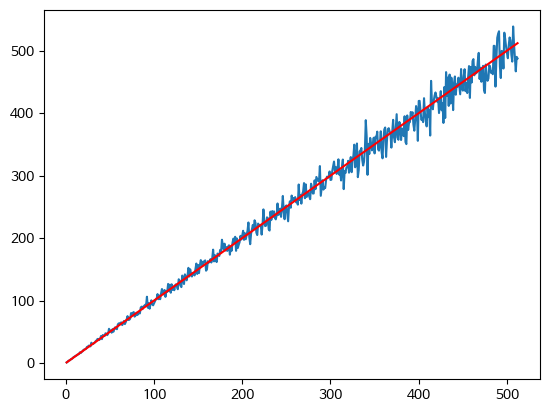

In [ ]:
# 왜 scaling을 sqrt(dk) 로? <- 일단 나누는 이유: 안나누면 softmax로 들어갈때 분산이 크면 grad가 작아짐
n=torch.arange(1,513)
N=1000
result=[]
for ni in n:
    inner_prod = torch.zeros(N)
    for i in range(N):
        inner_prod[i] = torch.randn(ni,1).T@torch.randn(ni,1) # 내적값을 N번 구해서 var 구해보자
    result += [torch.var(inner_prod)]

plt.plot(n,result)
plt.plot(n,n,'r') # variance 가 점점커지니까 std로 나눠서 unit variance로 만들자는 것!

### Encoder

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.self_atten = MHA(d_model, n_heads)
        self.self_atten_LN = nn.LayerNorm(d_model)

        self.FF = FeedForward(d_model, d_ff, drop_p)
        self.FF_LN = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(drop_p)

    def forward(self, x, enc_mask):

        residual, atten_enc = self.self_atten(x, x, x, enc_mask) # 인코더에도 마스크가?!
        residual = self.dropout(residual)
        x = self.self_atten_LN(x + residual)

        residual = self.FF(x)
        residual = self.dropout(residual)
        x = self.FF_LN(x + residual)

        return x, atten_enc

class Encoder(nn.Module):
    def __init__(self, input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.scale = torch.sqrt(torch.tensor(d_model))
        self.input_embedding = input_embedding
        self.pos_embedding = nn.Embedding(max_len, d_model)

        self.dropout = nn.Dropout(drop_p)

        self.layers = nn.ModuleList([EncoderLayer(d_model, d_ff, n_heads, drop_p) for _ in range(n_layers)])

    def forward(self, src, mask, atten_map_save = False): # src.shape = 개단, mask.shape = 개헤단단

        pos = torch.arange(src.shape[1]).expand_as(src).to(DEVICE) # 개단

        x = self.scale*self.input_embedding(src) + self.pos_embedding(pos) # 개단차
        # self.scale 을 곱해주면 position 보다 token 정보를 더 보게 된다 (gradient에 self.scale 만큼이 더 곱해짐)
        x = self.dropout(x)

        atten_encs = torch.tensor([]).to(DEVICE)
        for layer in self.layers:
            x, atten_enc = layer(x, mask)
            if atten_map_save is True:
                atten_encs = torch.cat([atten_encs , atten_enc[0].unsqueeze(0)], dim=0) # 층헤단단 ㅋ

        return x, atten_encs

#### expand_as, nn.embedding 실험

In [ ]:
src = torch.randn(3,5) # 개단
pos = torch.arange(5).expand_as(src).to(DEVICE)
print(src)
print(pos)

tensor([[-0.9167,  0.6734, -0.4509,  0.4858,  0.8737],
        [-0.7553,  0.5952,  0.1280,  0.0700,  0.8801],
        [ 1.6790,  1.2980, -1.8116, -0.0711,  1.4209]])
tensor([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]])


In [ ]:
# nn.Embedding 실험
emb=nn.Embedding(10,5) # one-hot encoding 된 벡터가 통과된다는 것이 약속된 상태의 FC layer 인 것
print(emb.weight.shape) # weight 개수는 nn.Linear(10,5) 과 동일! 동작 방식이 다른 것
print(emb(torch.tensor(2)))

print(emb(torch.tensor([[6,1,2],[2,1,7]]))) # 2 개 문장, 3개 단어
print(emb(torch.tensor([[6,1,2],[2,1,7]])).shape)

torch.Size([10, 5])
tensor([-0.3890, -0.3947, -0.1002,  0.6274, -0.7930],
       grad_fn=<EmbeddingBackward0>)
tensor([[[-1.2740,  0.5692,  1.4260, -2.3240, -1.1743],
         [ 0.8761, -0.0868,  0.3428,  2.2290, -0.8240],
         [-0.3890, -0.3947, -0.1002,  0.6274, -0.7930]],

        [[-0.3890, -0.3947, -0.1002,  0.6274, -0.7930],
         [ 0.8761, -0.0868,  0.3428,  2.2290, -0.8240],
         [-1.2618,  0.2368, -1.7425,  0.0215, -0.9853]]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([2, 3, 5])


### Decoder, 모델 전체

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.self_atten = MHA(d_model, n_heads)
        self.self_atten_LN = nn.LayerNorm(d_model)

        self.enc_dec_atten = MHA(d_model, n_heads)
        self.enc_dec_atten_LN = nn.LayerNorm(d_model)

        self.FF = FeedForward(d_model, d_ff, drop_p)
        self.FF_LN = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(drop_p)

    def forward(self, x, enc_out, dec_mask, enc_dec_mask):

        residual, atten_dec = self.self_atten(x, x, x, dec_mask)
        residual = self.dropout(residual)
        x = self.self_atten_LN(x + residual)

        residual, atten_enc_dec = self.enc_dec_atten(x, enc_out, enc_out, enc_dec_mask) # Q는 디코더로부터 K,V는 인코더로부터!!
        residual = self.dropout(residual)
        x = self.enc_dec_atten_LN(x + residual)

        residual = self.FF(x)
        residual = self.dropout(residual)
        x = self.FF_LN(x + residual)

        return x, atten_dec, atten_enc_dec

class Decoder(nn.Module):
    def __init__(self, input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.scale = torch.sqrt(torch.tensor(d_model))
        self.input_embedding = input_embedding
        self.pos_embedding = nn.Embedding(max_len, d_model)

        self.dropout = nn.Dropout(drop_p)

        self.layers = nn.ModuleList([DecoderLayer(d_model, d_ff, n_heads, drop_p) for _ in range(n_layers)])

        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, trg, enc_out, dec_mask, enc_dec_mask, atten_map_save = False): # trg.shape = 개단, enc_out.shape = 개단차, dec_mask.shape = 개헤단단

        pos = torch.arange(trg.shape[1]).expand_as(trg).to(DEVICE) # 개단

        x = self.scale*self.input_embedding(trg) + self.pos_embedding(pos) # 개단차
        # self.scale 을 곱해주면 position 보다 token 정보를 더 보게 된다 (gradient에 self.scale 만큼이 더 곱해짐)
        x = self.dropout(x)

        atten_decs = torch.tensor([]).to(DEVICE)
        atten_enc_decs = torch.tensor([]).to(DEVICE)
        for layer in self.layers:
            x, atten_dec, atten_enc_dec = layer(x, enc_out, dec_mask, enc_dec_mask)
            if atten_map_save is True:
                atten_decs = torch.cat([atten_decs , atten_dec[0].unsqueeze(0)], dim=0) # 층헤단단 ㅋ
                atten_enc_decs = torch.cat([atten_enc_decs , atten_enc_dec[0].unsqueeze(0)], dim=0) # 층헤단단 ㅋ

        x = self.fc_out(x)

        return x, atten_decs, atten_enc_decs

In [ ]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.input_embedding = nn.Embedding(vocab_size, d_model)
        self.encoder = Encoder(self.input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p)
        self.decoder = Decoder(self.input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p)

        self.n_heads = n_heads

        # for m in self.modules():
        #     if hasattr(m,'weight') and m.weight.dim() > 1: # layer norm에 대해선 initial 안하겠다는 뜻
        #         nn.init.kaiming_uniform_(m.weight) # Kaiming의 분산은 2/Nin

        for m in self.modules():
            if hasattr(m,'weight') and m.weight.dim() > 1: # 인풋 임베딩은 그대로 쓰기 위함
                nn.init.xavier_uniform_(m.weight) # xavier의 분산은 2/(Nin+Nout) 즉, 분산이 더 작다. => 그래서 sigmoid/tanh에 적합한 것! (vanishing gradient 막기 위해)

    def make_enc_mask(self, src): # src.shape = 개단

        enc_mask = (src == pad_idx).unsqueeze(1).unsqueeze(2) # 개11단
        enc_mask = enc_mask.expand(src.shape[0], self.n_heads, src.shape[1], src.shape[1]) # 개헤단단
        """ src pad mask (문장 마다 다르게 생김. 이건 한 문장에 대한 pad 행렬)
        F F T T
        F F T T
        F F T T
        F F T T
        """
        return enc_mask

    def make_dec_mask(self, trg): # trg.shape = 개단

        trg_pad_mask = (trg == pad_idx).unsqueeze(1).unsqueeze(2) # 개11단
        trg_pad_mask = trg_pad_mask.expand(trg.shape[0], self.n_heads, trg.shape[1], trg.shape[1]) # 개헤단단
        """ trg pad mask
        F F F T T
        F F F T T
        F F F T T
        F F F T T
        F F F T T
        """
        trg_future_mask = torch.tril(torch.ones(trg.shape[0], self.n_heads, trg.shape[1], trg.shape[1]))==0 # 개헤단단
        trg_future_mask = trg_future_mask.to(DEVICE) # pad_mask | future_mask 할 때 같은 DEVICE 여야
        """ trg future mask
        F T T T T
        F F T T T
        F F F T T
        F F F F T
        F F F F F
        """
        dec_mask = trg_pad_mask | trg_future_mask # dec_mask.shape = 개헤단단
        """ decoder mask
        F T T T T
        F F T T T
        F F F T T
        F F F T T
        F F F T T
        """
        return dec_mask

    def make_enc_dec_mask(self, src, trg):

        enc_dec_mask = (src == pad_idx).unsqueeze(1).unsqueeze(2) # 개11단
        enc_dec_mask = enc_dec_mask.expand(trg.shape[0], self.n_heads, trg.shape[1], src.shape[1]) # 개헤단단
        """ src pad mask
        F F T T
        F F T T
        F F T T
        F F T T
        F F T T
        """
        return enc_dec_mask

    def forward(self, src, trg):

        enc_mask = self.make_enc_mask(src)
        dec_mask = self.make_dec_mask(trg)
        enc_dec_mask = self.make_enc_dec_mask(src, trg)

        enc_out, atten_encs = self.encoder(src, enc_mask)
        out, atten_decs, atten_enc_decs = self.decoder(trg, enc_out, dec_mask, enc_dec_mask)

        return out, atten_encs, atten_decs, atten_enc_decs

#### tril, initialization 실험

In [ ]:
# 즉, Layer norm은 initialization에서 제외!
print(nn.LayerNorm(10).weight)
print(nn.LayerNorm(10).weight.dim())

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)
1


In [ ]:
# Kaiming vs Xavier
layer = nn.Linear(2,10)
print(layer.weight)
nn.init.kaiming_uniform_(layer.weight)
print(layer.weight) # in 만 보니까 분산 크다
nn.init.xavier_uniform_(layer.weight)
print(layer.weight) # in out 둘다 보니까 분산 작다

Parameter containing:
tensor([[-0.0728,  0.4038],
        [-0.3477, -0.0703],
        [ 0.1837, -0.6112],
        [-0.2559, -0.5160],
        [-0.4576, -0.4055],
        [-0.0198,  0.6441],
        [-0.6524, -0.0883],
        [-0.2571,  0.2978],
        [-0.1733,  0.0841],
        [ 0.2591,  0.2502]], requires_grad=True)
Parameter containing:
tensor([[ 1.4248,  1.2274],
        [ 1.3466,  0.9589],
        [ 0.5012,  1.0482],
        [-0.4071, -1.1700],
        [-0.6329,  0.3741],
        [ 0.4563,  1.5046],
        [-1.6281, -0.5586],
        [-1.7288,  1.4485],
        [-0.4562,  0.2811],
        [-0.8675,  0.1869]], requires_grad=True)
Parameter containing:
tensor([[ 0.6965,  0.6854],
        [-0.6411,  0.3372],
        [-0.4472, -0.3432],
        [-0.0140, -0.0033],
        [ 0.2006,  0.6243],
        [ 0.3798, -0.3539],
        [ 0.4334,  0.4258],
        [ 0.6551, -0.1144],
        [-0.5321,  0.1058],
        [ 0.3599, -0.5334]], requires_grad=True)


In [ ]:
x = torch.ones(2,3,5,5)
x = torch.tril(x) # tril: lower triangular
print(x)

tensor([[[[1., 0., 0., 0., 0.],
          [1., 1., 0., 0., 0.],
          [1., 1., 1., 0., 0.],
          [1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1.]],

         [[1., 0., 0., 0., 0.],
          [1., 1., 0., 0., 0.],
          [1., 1., 1., 0., 0.],
          [1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1.]],

         [[1., 0., 0., 0., 0.],
          [1., 1., 0., 0., 0.],
          [1., 1., 1., 0., 0.],
          [1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1.]]],


        [[[1., 0., 0., 0., 0.],
          [1., 1., 0., 0., 0.],
          [1., 1., 1., 0., 0.],
          [1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1.]],

         [[1., 0., 0., 0., 0.],
          [1., 1., 0., 0., 0.],
          [1., 1., 1., 0., 0.],
          [1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1.]],

         [[1., 0., 0., 0., 0.],
          [1., 1., 0., 0., 0.],
          [1., 1., 1., 0., 0.],
          [1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1.]]]])


## 모델 생성

In [ ]:
model = Transformer(vocab_size, max_len, n_layers, d_model, d_ff, n_heads, drop_p).to(DEVICE)

src = torch.tensor([[4,6,5,1,1,1],[7,7,1,1,1,1]]).to(DEVICE)
trg = torch.tensor([[2,5,4,4,3,1,1],[2,9,6,7,3,1,1]]).to(DEVICE)

model.eval()
with torch.no_grad():
    x = model(src, trg)[0]
print(trg.shape)
print(x.shape)

torch.Size([2, 7])
torch.Size([2, 7, 65001])


## Train, Test, loss_epoch 함수

In [ ]:
def Train(model, train_DL, val_DL, criterion, optimizer, scheduler = None):
    loss_history = {"train": [], "val": []}
    best_loss = 9999
    for ep in range(EPOCH):
        model.train() # train mode로 전환
        train_loss = loss_epoch(model, train_DL, criterion, optimizer = optimizer, scheduler = scheduler)
        loss_history["train"] += [train_loss]

        model.eval() # test mode로 전환
        with torch.no_grad():
            val_loss = loss_epoch(model, val_DL, criterion)
            loss_history["val"] += [val_loss]
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save({"model": model,
                            "ep": ep,
                            "optimizer": optimizer,
                            "scheduler": scheduler,}, save_model_path)
        # print loss
        print(f"Epoch {ep+1}: train loss: {train_loss:.5f}   val loss: {val_loss:.5f}   current_LR: {optimizer.param_groups[0]['lr']:.8f}")
        print("-" * 20)

    torch.save({"loss_history": loss_history,
                "EPOCH": EPOCH,
                "BATCH_SIZE": BATCH_SIZE}, save_history_path)

def Test(model, test_DL, criterion):
    model.eval() # test mode로 전환
    with torch.no_grad():
        test_loss = loss_epoch(model, test_DL, criterion)
    print(f"Test loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}")

def loss_epoch(model, DL, criterion, optimizer = None, scheduler = None):
    N = len(DL.dataset) # the number of data

    rloss=0
    for src_texts, trg_texts in tqdm(DL, leave=False):
        src = tokenizer(src_texts, padding=True, truncation=True, max_length = max_len, return_tensors='pt').input_ids.to(DEVICE)
        trg_texts = ['</s> ' + s for s in trg_texts]
        trg = tokenizer(trg_texts, padding=True, truncation=True, max_length = max_len, return_tensors='pt').input_ids.to(DEVICE)
        # inference
        y_hat = model(src, trg[:,:-1])[0] # 모델 통과 시킬 땐 trg의 마지막 토큰은 제외!
        # y_hat.shape = 개단차 즉, 훈련 땐 문장이 한번에 튀어나옴
        # loss
        loss = criterion(y_hat.permute(0,2,1), trg[:,1:]) # loss 계산 시엔 <sos> 는 제외!
        """
        개단차 -> 개차단으로 바꿔줌 (1D segmentation으로 생각)
        개채행열(예측), 개행열(정답)으로 주거나 개채1열, 개1열로 주거나 개채열, 개열로 줘야하도록 함수를 만들어놔서
        우리 상황에서는 개차단, 개단 으로 줘야 한다.
        이렇게 함수를 만들어놔야 1D, 2D segmentation 등등으로 확장가능하기 때문
        다 필요없고, 그냥 y_hat=개차단, trg=개단으로 줘야만 계산 제대로 된다고 생각하시면 됩니다!
        """
        # update
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if scheduler is not None:
            scheduler.step()
        # loss accumulation
        loss_b = loss.item() * src.shape[0]
        rloss += loss_b
    loss_e = rloss/N
    return loss_e

def count_params(model):
    num = sum([p.numel() for p in model.parameters() if p.requires_grad])
    return num

class NoamScheduler:
    def __init__(self, optimizer, d_model, warmup_steps, LR_scale = 1):
        self.optimizer = optimizer
        self.current_step = 0
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.LR_scale = LR_scale

    def step(self):
        self.current_step += 1
        lrate = self.LR_scale * (self.d_model ** -0.5) * min(self.current_step ** -0.5, self.current_step * self.warmup_steps ** -1.5)
        self.optimizer.param_groups[0]['lr'] = lrate

def plot_scheduler(scheduler_name, optimizer, scheduler, total_steps): # LR curve 보기
    lr_history = []
    steps = range(1, total_steps)

    for _ in steps: # base model -> 10만 steps (12시간), big model -> 30만 steps (3.5일) 로 훈련했다고 함
        lr_history += [optimizer.param_groups[0]['lr']]
        scheduler.step()

    plt.figure()
    if scheduler_name == 'Noam':
        if total_steps == 100000:
            plt.plot(steps, (512 ** -0.5) * torch.tensor(steps) ** -0.5, 'g--', linewidth=1, label=r"$d_{\mathrm{model}}^{-0.5} \cdot \mathrm{step}^{-0.5}$")
            plt.plot(steps, (512 ** -0.5) * torch.tensor(steps) * 4000 ** -1.5, 'r--', linewidth=1, label=r"$d_{\mathrm{model}}^{-0.5} \cdot \mathrm{step} \cdot \mathrm{warmup\_steps}^{-1.5}$")
        plt.plot(steps, lr_history, 'b', linewidth=2, alpha=0.8, label="Learning Rate")
    elif scheduler_name == 'Cos':
        plt.plot(steps, lr_history, 'b', linewidth=2, alpha=0.8, label="Learning Rate")
    plt.ylim([-0.1*max(lr_history), 1.2*max(lr_history)])
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.grid()
    plt.legend()
    plt.show()

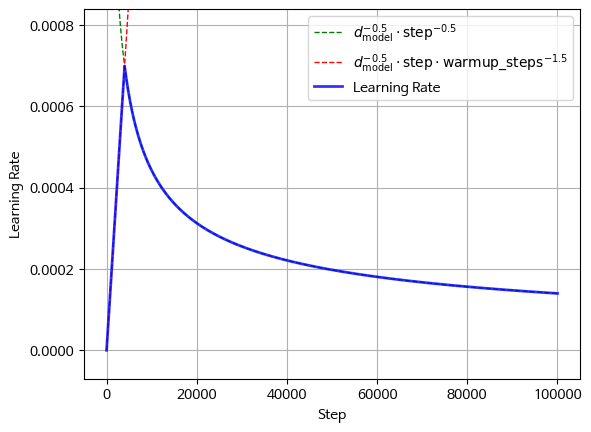

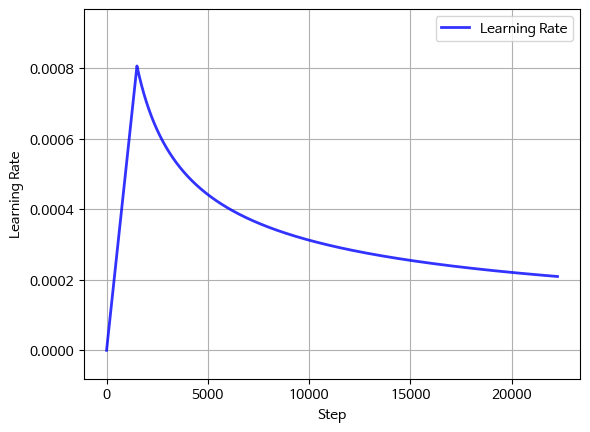

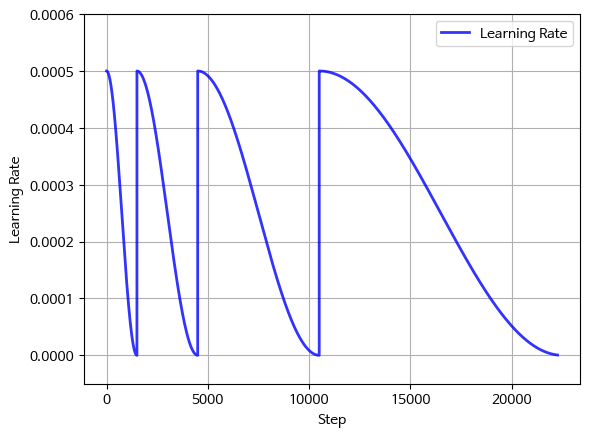

In [ ]:
optimizer = optim.Adam(nn.Linear(1, 1).parameters(), lr=0) # 테스트용 optimizer
scheduler = NoamScheduler(optimizer, d_model=512, warmup_steps=4000) # 논문 값
plot_scheduler(scheduler_name = 'Noam', optimizer = optimizer, scheduler = scheduler, total_steps = 100000)

optimizer = optim.Adam(nn.Linear(1, 1).parameters(), lr=0)
scheduler = NoamScheduler(optimizer, d_model=d_model, warmup_steps=warmup_steps, LR_scale=LR_scale)
plot_scheduler(scheduler_name = 'Noam', optimizer = optimizer, scheduler = scheduler, total_steps = int(len(train_DS)*EPOCH/BATCH_SIZE)) # 내 상황

optimizer = optim.Adam(nn.Linear(1, 1).parameters(), lr=LR_init)
scheduler = CosineAnnealingWarmRestarts(optimizer, T0, T_mult)
plot_scheduler(scheduler_name = 'Cos', optimizer = optimizer, scheduler = scheduler, total_steps = int(len(train_DS)*EPOCH/BATCH_SIZE))

## 모델 학습

In [ ]:
if new_model_train:
    params = [p for p in model.parameters() if p.requires_grad] # 사전 학습된 layer를 사용할 경우
    if scheduler_name == 'Noam':
        optimizer = optim.Adam(params, lr=0,
                               betas=(0.9, 0.98), eps=1e-9,
                               weight_decay=LAMBDA) # 논문에서 제시한 beta와 eps 사용, l2-Regularization은 한번 써봄 & 맨 처음 step 의 LR=0으로 출발 (warm-up)
        scheduler = NoamScheduler(optimizer, d_model=d_model, warmup_steps=warmup_steps, LR_scale=LR_scale)

    elif scheduler_name == 'Cos':
        optimizer = optim.Adam(params, lr=LR_init,  # cos restart sheduling
                               betas=(0.9, 0.98), eps=1e-9,
                               weight_decay=LAMBDA)
        scheduler = CosineAnnealingWarmRestarts(optimizer, T0, T_mult)

    Train(model, train_DL, val_DL, criterion, optimizer, scheduler)

## 로드 모델

In [ ]:
loaded = torch.load(save_model_path, map_location=DEVICE)
load_model = loaded["model"]
ep = loaded["ep"]
optimizer = loaded["optimizer"]

loaded = torch.load(save_history_path, map_location=DEVICE)
loss_history = loaded["loss_history"]

print(ep)
print(optimizer)

11
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.98)
    capturable: False
    differentiable: False
    eps: 1e-09
    foreach: None
    fused: None
    lr: 0.00023409717446640351
    maximize: False
    weight_decay: 0
)


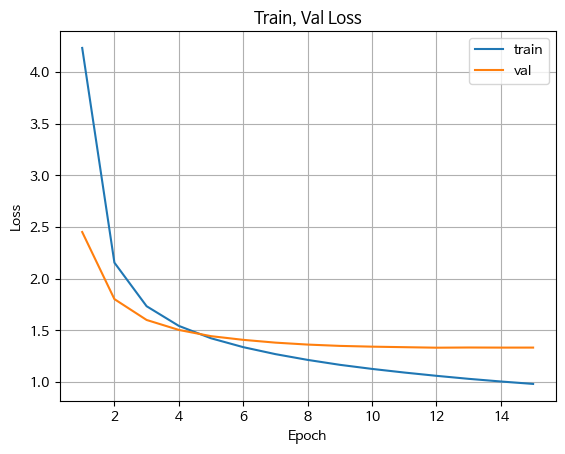

In [ ]:
plt.figure()
plt.plot(range(1,EPOCH+1),loss_history["train"], label="train")
plt.plot(range(1,EPOCH+1),loss_history["val"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.grid()
plt.legend()

In [ ]:
Test(load_model, test_DL, criterion) # test data에 모델 학습 당시의 train 문장이 껴들어가 있어서 낮게 나옴
                                     # (random_split으로 코드 전체 돌릴 때마다 test_DS 를 새로 만들다보니..)
count_params(load_model)

Test loss: 0.864 | Test PPL: 2.372


37350377

In [ ]:
# Perplxity 구하기
y_hat = torch.tensor([[[0.3659, 0.7025, 0.3104]], [[0.0097, 0.6577, 0.1947]],[[0.5659, 0.0025, 0.0104]], [[0.9097, 0.0577, 0.7947]]])
target = torch.tensor([[2],  [1], [2],  [1]])

soft = nn.Softmax(dim=-1)
y_hat_soft = soft(y_hat)
print(y_hat_soft.shape)
v=1
for i, val in enumerate(y_hat_soft):
    v*=val[0,target[i]]
print(v**(-1/target.shape[0]))
# 3.5257

criterion_test = nn.CrossEntropyLoss()
print(y_hat.permute(0,2,1).shape)
print(target.shape)
print(torch.exp(criterion_test(y_hat.permute(0,2,1), target))) # 결론: loss에 torch.exp 취하셈
# 3.5257

torch.Size([4, 1, 3])
tensor([3.5257])
torch.Size([4, 3, 1])
torch.Size([4, 1])
tensor(3.5257)


## 번역 함수, 어텐션 map 그리는 함수

In [ ]:
def translation(model, src_text, atten_map_save = False):
    model.eval()
    with torch.no_grad():
        src = tokenizer.encode(src_text, return_tensors='pt').to(DEVICE) # 1x단
        enc_mask = model.make_enc_mask(src)
        enc_out, atten_encs = model.encoder(src, enc_mask, atten_map_save)

        pred = tokenizer.encode('</s>', return_tensors='pt', add_special_tokens=False).to(DEVICE) # 1x1
        for _ in range(max_len-1): # <sos> 가 한 토큰이기 때문에 최대 99 번까지만 loop을 돌아야 함
            dec_mask = model.make_dec_mask(pred)
            enc_dec_mask = model.make_enc_dec_mask(src, pred)
            out, atten_decs, atten_enc_decs = model.decoder(pred, enc_out, dec_mask, enc_dec_mask, atten_map_save)
            # out.shape = (개=1,단,차)

            pred_word = out[:,-1,:].argmax(dim=1).unsqueeze(0) # 마지막 단어에 대해 argmax해서 prediction 하고 shape = (1,1)로
            pred = torch.cat([pred, pred_word], dim=1) # 1x단 (단은 하나씩 늘면서)

            if tokenizer.decode(pred_word.item()) == '</s>':
                break

        translated_text = tokenizer.decode(pred[0])

    return translated_text, atten_encs, atten_decs, atten_enc_decs

def show_attention(atten, Query, Key, n):
    atten = atten.cpu()

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[atten.shape[3]*1.5,atten.shape[2]])
    for i in range(3):
        ax[i].set_yticks(range(atten.shape[2]))
        ax[i].set_yticklabels(Query, rotation=45)
        ax[i].set_xticks(range(atten.shape[3]))
        ax[i].set_xticklabels(Key, rotation=60)
        ax[i].imshow(atten[n][i], cmap='bone') # n 번째 layer, 앞 세 개의 헤드만 plot
        # ax[i].xaxis.tick_top()  # x축 레이블을 위쪽으로 이동

In [ ]:
# 번역해보기
i = 4
idx = test_DS.indices[i]
src_text, trg_text = custom_DS.__getitem__(idx)
print(f"입력: {src_text}")
print(f"정답: {trg_text}")

translated_text, atten_encs, atten_decs, atten_enc_decs = translation(load_model, src_text, atten_map_save = True)
print(f"AI의 번역: {translated_text}")

입력: 저는 홍차로 할게요, 친구는 아마 커피를 마실 거예요.
정답: I will have black tea, my friend will probably have coffee.
AI의 번역: </s> I'll have a red tea, my friend will probably drink coffee.</s>


In [ ]:
# # teacher forcing 으로 넣어본다면?

# src = tokenizer.encode(src_text, return_tensors='pt').to(DEVICE)
# trg_text = '</s> ' + trg_text
# trg = tokenizer.encode(trg_text, return_tensors='pt').to(DEVICE)

# load_model.eval()
# with torch.no_grad():
#     y_hat = load_model(src, trg[:,:-1])[0]
#     loss = criterion(y_hat.permute(0,2,1), trg[:,1:])
#     out_token = y_hat.argmax(-1).squeeze()
#     out_text = tokenizer.decode(out_token)

# print('loss =', loss)
# print('정답 =', [tokenizer.decode(i) for i in trg[0,1:]])
# print('예측 =', [tokenizer.decode(i) for i in out_token])

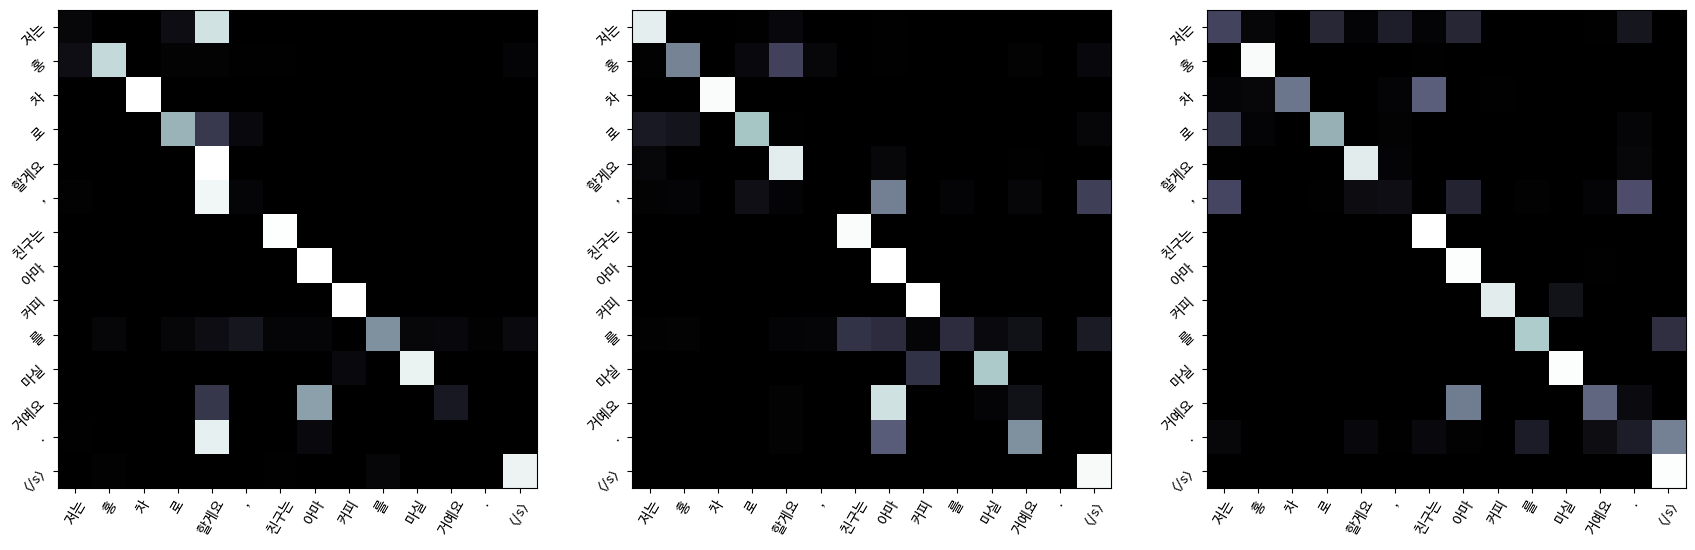

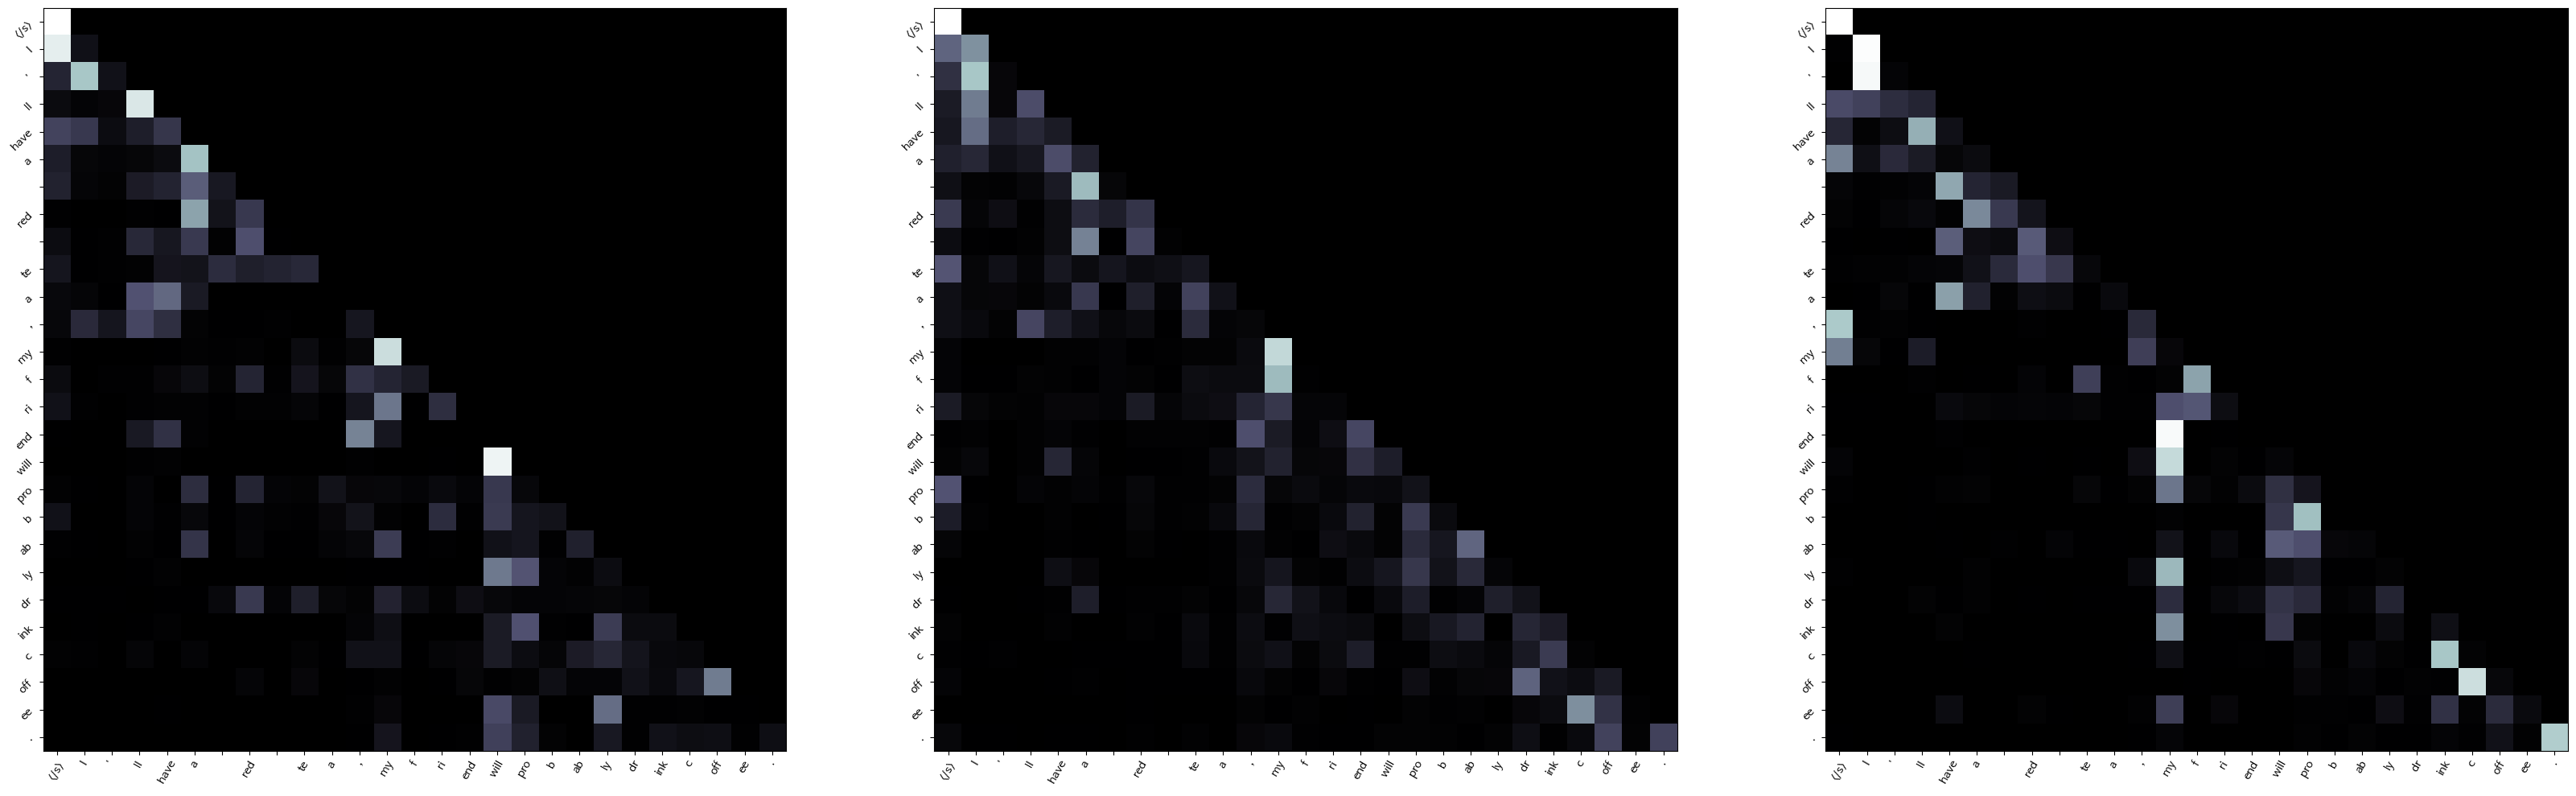

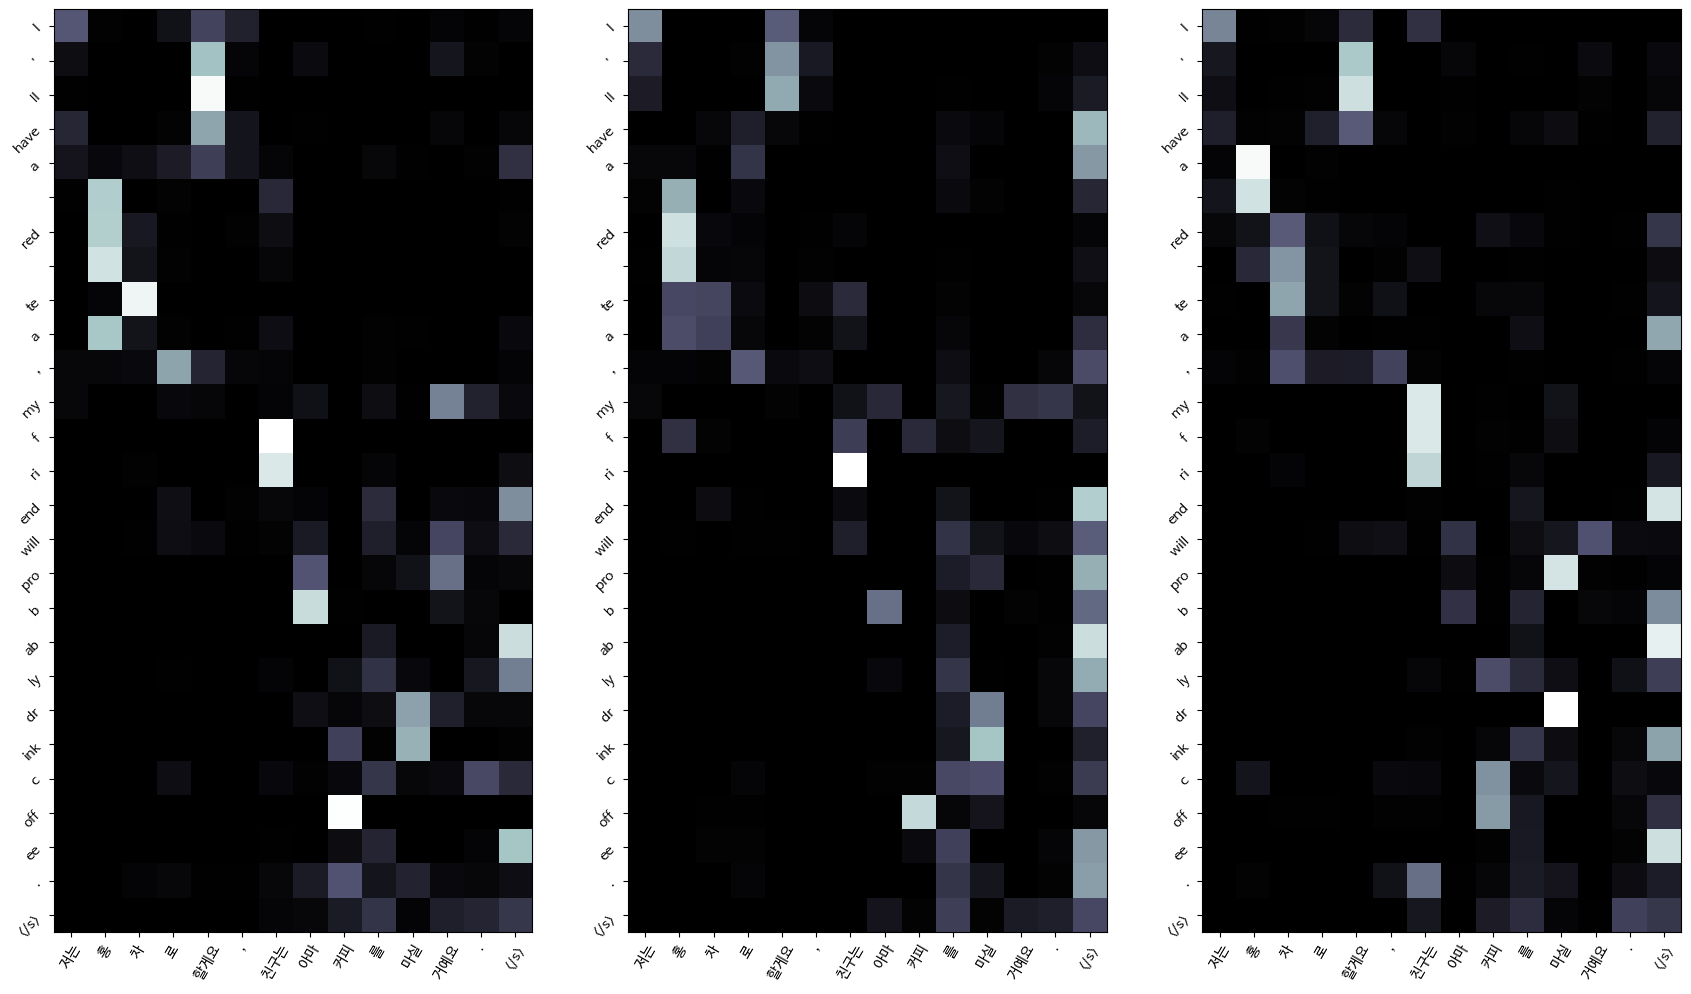

In [ ]:
enc_input = tokenizer.tokenize(src_text+' </s>') # <eos> 붙여서 학습 시켰기 때문에 여기도 붙여줘야
dec_tokens = tokenizer.tokenize(translated_text)
dec_input = dec_tokens[:-1] # 디코더 입력으로 들어가는 문장(sos 는 있고 eos는 없고)
dec_output = dec_tokens[1:] # 디코더 출력으로 나간 문장

# print(dec_input)
# print(atten_enc_dec.shape)
# print(len(dec_input))
# print(len(enc_input))

show_attention(atten_encs, enc_input, enc_input, n = 2) # 백화점 1층은 사원 헤드 (두루두루) 2층은 부장 헤드 3층은 임원 헤드
show_attention(atten_decs, dec_input, dec_input, n = 2)
show_attention(atten_enc_decs, dec_output, enc_input, n = 2) # 이 map을 해석할 때는 "이 단어가 나오게끔 뭘 주목했느냐" 로 해석해줘야 함 (ytick에 들어가는 단어가 아닌 예측한 단어를 썼기 때문)

## BLEU score 구하기

In [ ]:
from torchtext.data.metrics import bleu_score

# trgs = [[['훌륭한', '강사와', '훌륭한', '수강생이','만나면','명강의가', '탄생한다']]]
# preds = [['훌륭한', '강사와', '훌륭한', '수강생이','함께라면','명강의가','만들어진다']]
# preds = [['만들어진다', '강사와', '훌륭한', '명강의가','훌륭한','수강생이','함께라면']]
# preds = [['훌륭한', '강사와', '훌륭한', '수강생이','훌륭한','강사와','훌륭한','강의를', '만든다']]
# preds = [['수강생이', '만나면', '명강의가', '탄생한다']]

trgs = [[['훌륭한', '강사와', '훌륭한', '수강생이','만나면','명강의가', '탄생한다']], [['이것은', '두','번째','문장입니다']]]
preds = [['훌륭한', '강사와', '훌륭한', '수강생이','훌륭한','강의를','만든다'], ['이것은','문장입니다']]

bleu_score(preds, trgs, max_n = 4, weights = [0.25,0.25,0.25,0.25]) # default
# bleu_score(preds, trgs, max_n = 1, weights = [1])

0.32921006485865717

In [ ]:
def calc_bleu_score(model, DS):
    trgs = []
    preds = []

    for i, (src_text, trg_text) in enumerate(DS):

        translated_text, _, _, _ = translation(load_model, src_text)

        trg = tokenizer.tokenize(trg_text)
        translated_tok = tokenizer.tokenize(translated_text)[1:-1] # <sos> & <eos> 제외

        trgs += [[trg]]
        preds += [translated_tok]

        if (i + 1) % 100 == 0:
            print(f"[{i + 1}/{len(DS)}]")
            print(f"입력: {src_text}")
            print(f"정답: {trg_text}")
            print(f"AI의 번역: {translated_text[5:-4]}") # 문자열에서 </s> 안보이게 하려고..

    bleu = bleu_score(preds, trgs)
    print()
    print(f'Total BLEU Score = {bleu*100:.2f}')

In [ ]:
calc_bleu_score(load_model, test_DS)

[100/1000]
입력: 방금 제 집에 도둑이 든 것 같아서 신고합니다.
정답: I'm reporting because I think my house has just been robbed.
AI의 번역: I'm afraid I just am just going home because I think my house at home.
[200/1000]
입력: 네. 감사합니다. 깨끗해야 편하게 쉴 수 있을 것 같아서요.
정답: Okay. Thank you. I need a clean room to get a good rest.
AI의 번역: Yes. Thank you. I think I can rest after cleaning.
[300/1000]
입력: 우리 회사의 현재 재무 상태는 어떤가요?
정답: How's the current financial status of our company?
AI의 번역: How is our financial status now?
[400/1000]
입력: 새시 포함해서 빌라 전체 수리 견적 요청합니다.
정답: Please give me a quote for repairing the entire villa including the sashes.
AI의 번역: I'd like to request a quotation including a new one.
[500/1000]
입력: 아니요, 이제 막 복귀하여 확인하지 못하였습니다.
정답: No, I just came back so I haven't checked yet.
AI의 번역: No, I just checked out and couldn't check it.
[600/1000]
입력: 안녕하세요. 여권 주세요. 그리고 여행용 가방도 올려주세요.
정답: Hi. Please show me your passport. And please place your luggage up here.
AI의 번역: Hello. Please give me your passport. And pleas

In [ ]:
# 내 번역기 써보기!
src_text = "여러분! 이 강의 정말 열심히 준비 했어요."
print(f"입력: {src_text}")

translated_text = translation(load_model, src_text)[0]
print(f"AI의 번역: {translated_text}")

입력: 여러분! 이 강의 정말 열심히 준비 했어요.
AI의 번역: </s> Everyone! I've worked hard to prepare this lecture.</s>
